In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score

In [2]:
# Cargando dataset
file_path = 'dataset/anaemia.csv' 
df = pd.read_csv(file_path)

In [3]:
# Eliminando espacios en blanco en la columna Sex
df['Sex'] = df['Sex'].str.strip()

encoder = LabelEncoder()

df['Sex'] = encoder.fit_transform(df['Sex'])

df['Anaemic'] = encoder.fit_transform(df['Anaemic'])

In [4]:
# Seleccionando  variables independientes y variable objetivo
X = df[['Number', 'Sex', '%Red Pixel', '%Green pixel', '%Blue pixel', 'Hb']]
y = df['Anaemic']

In [5]:
# Separando los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=314)

In [6]:
# Creando modelo Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=314)

# Escalando datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Entrenando modelo
random_forest_model.fit(X_train_scaled, y_train)

# Prediciendo valores
y_pred = random_forest_model.predict(X_test_scaled)

In [7]:
# Evaluando modelo
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00         7

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

[[25  0]
 [ 0  7]]


In [8]:
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

Recall: 1.00
Precision: 1.00
F1 Score: 1.0


In [9]:
kfold = KFold(n_splits=5, shuffle=True, random_state=314)

results = cross_val_score(random_forest_model, X, y, cv=kfold, scoring='accuracy')
print(f"Accuracy: {results.mean():.2f} (+/- {results.std():.2f})")

Accuracy: 0.96 (+/- 0.04)


# Analisis SHAP

In [10]:
import seaborn as sns
import shap
import numpy as np
shap.initjs()

In [11]:
explainer = shap.TreeExplainer(random_forest_model)
shap_values = np.array(explainer.shap_values(X_train_scaled))
shap_values.shape

(72, 6, 2)

In [12]:
shap_values_ = shap_values.transpose(2, 0, 1)
shap_values_.shape

(2, 72, 6)

## SHAP Summary Plot

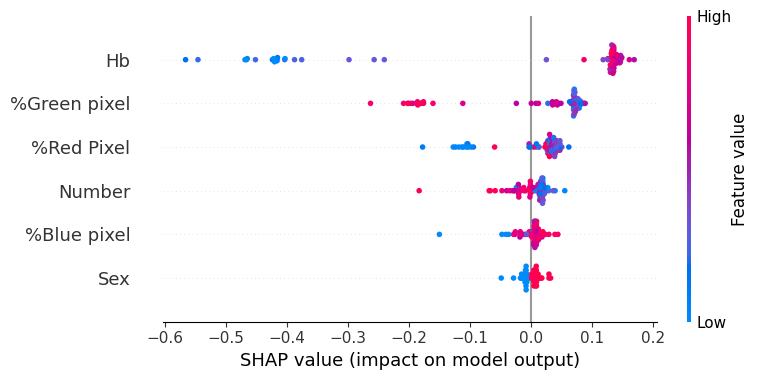

In [13]:
shap.summary_plot(shap_values_[0],X_train_scaled)

Al predecir que la persona no tiene anemia, la variable Hb es la que más influye en el modelo de predicción.

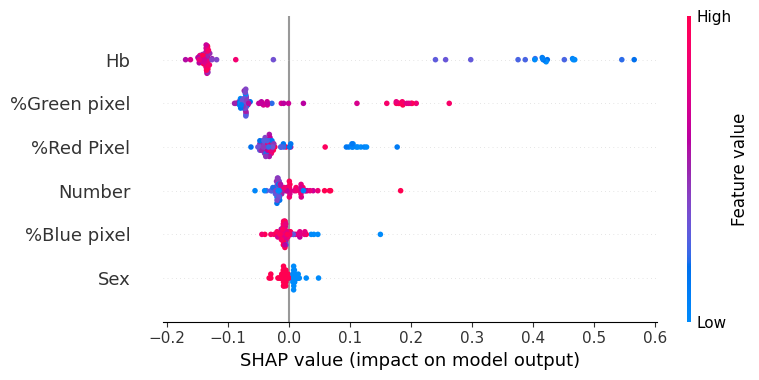

In [14]:
shap.summary_plot(shap_values_[1],X_train_scaled)


En este caso, cuando se predice si la persona si tiene anemia, el orden de influencia de las variables es el mismo que cuando se predice si una persona no tiene anemia.

## SHAP Dependence Plots

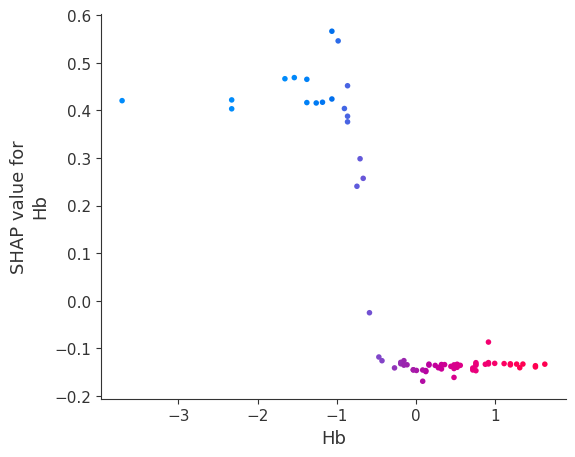

In [15]:
# SHAP dependence plot - Analizando como la variable Hb afecta a la predecir si un paciente tiene anemia
shap.dependence_plot('Hb', shap_values_[1], X_train_scaled, interaction_index='Hb')

Hb tiene un impacto significativo en la predicción de que un paciente tenga anemia, especialmente cuando la persona tiene niveles de Hb bajos.

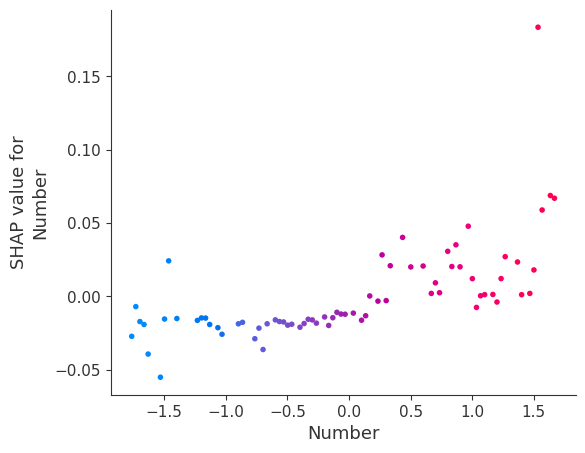

In [16]:
# SHAP dependence plot - Analizando como la variable Number afecta a la predicción del modelo
shap.dependence_plot('Number', shap_values_[1], X_train_scaled, interaction_index='Number')

Los valores menores a 0 de la variable Number muestran un impacto mínimo en la predicción del modelo. Sin embargo, a medida que el valor de la variable Number aumenta, también su impacto en las predicciones del modelo aumenta.

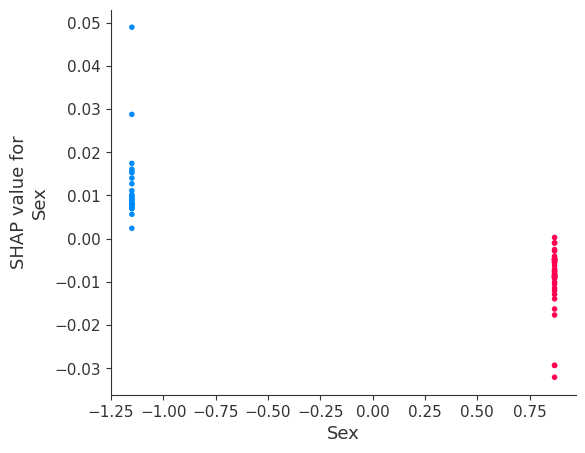

In [17]:
# SHAP dependence plot - Analizando como la variable Sex afecta a la predicción del modelo
shap.dependence_plot('Sex', shap_values_[1], X_train_scaled, interaction_index='Sex')

El impacto de la variable Sex en las predicciones del modelo es relativamente pequeño en comparación con otras variables.

## SHAP Force Plots

In [22]:
class_type = 0 # Sin anemia
instance = 0
shap_values_subset = shap_values_[class_type][instance]
shap.plots.force(explainer.expected_value[class_type], shap_values_subset, X_train_scaled.iloc[instance])

Las variables Hb y Red Pixel redujeron el valor de la predicción final, para la primera instancia del dataset. Mientras que, Green pixel aumentó el valor de la predicción final. En este caso, estas fueron las variables que más influenciaron el resultado final, moviendo el valor base hacia abajo.

In [25]:
class_type = 1 # Sin anemia
instance = 0
shap_values_subset = shap_values_[class_type][instance]
shap.plots.force(explainer.expected_value[class_type], shap_values_subset, X_train_scaled.iloc[instance])

Se ve el mismo efecto que en el caso anterior, pero de forma inversa. Las variables movieron al valor base hacia arriba.

In [23]:
class_type = 0 # Sin anemia
instance = 10
shap_values_subset = shap_values_[class_type][instance]
shap.plots.force(explainer.expected_value[class_type], shap_values_subset, X_train_scaled.iloc[instance])

En este caso, se muestra la influencia de más variables que empujaron el valor base hacia arriba.

In [26]:
class_type = 1 # Sin anemia
instance = 10
shap_values_subset = shap_values_[class_type][instance]
shap.plots.force(explainer.expected_value[class_type], shap_values_subset, X_train_scaled.iloc[instance])

Se ve el mismo efecto que en caso anterior, pero de forma inversa, las variables mueven al valor base hacia arriba.

In [19]:
class_type = 0 # Sin anemia
shap_values_subset = shap_values_[class_type][:]
shap.plots.force(explainer.expected_value[class_type], shap_values_subset, X_train_scaled.iloc[:])

La variable Hb es la que más sobresale en las observaciones analizadas, subiendo o bajanda las predicciones dependiendo del caso. Seguida de la variable Green pixel y luego Red Pixel.

In [20]:
class_type = 1 # Con anemia
shap_values_subset = shap_values_[class_type][:]
shap.plots.force(explainer.expected_value[class_type], shap_values_subset, X_train_scaled.iloc[:])

La variable Hb es la que más sobresale en las observaciones analizadas, subiendo o bajanda las predicciones dependiendo del caso. Seguida de la variable Green pixel y luego Red Pixel.